In [ ]:
import os
import numpy as np
import scipy.signal
from scipy.io import wavfile
import scipy.io
import matplotlib.pyplot as plt
import ipywidgets

In [ ]:
file_list = os.listdir()
file_list = [file for file in file_list if '.wav' in file]
file_dropdown = ipywidgets.Dropdown(options=file_list)
file_dropdown

Dropdown(options=('garage_tamper_SDRSharp_20230909_003155Z_344257000Hz_IQ (1).wav',), value='garage_tamper_SDR…

In [ ]:
selected_file = file_dropdown.value
path = os.getcwd() + '/' + selected_file

- IQ samples were recorded as `.wav` files using SDRSharp.
- Sample rate of 2.4 MHz.
- Data are arranged in an n by 2 array where the 0th column contains real (I) values and the 1st column contains imaginary (Q) values.

In [ ]:
sr, data = wavfile.read(path)
real = data[:,0]
imag = 1j*data[:,1]
complex_data = real+imag
print(f'Sample Rate: {sr} Hz')

Sample Rate: 2400000 Hz


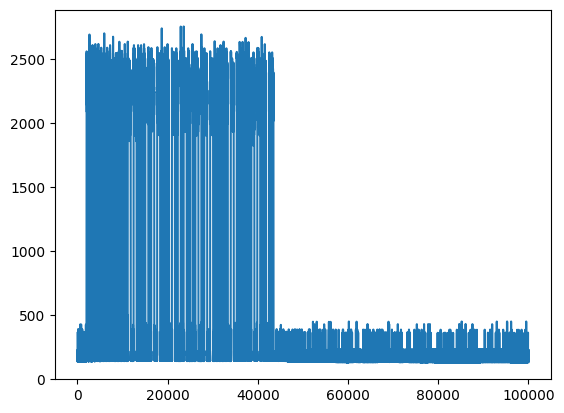

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.absolute(complex_data[2800000:2900000]))

## **Burst Detection**

Each file contains sections in which no signal is present. To identify locations that contain signal the power spectral density is calculated in a non-overlapping window containing `num_samples` using `scipy.signal.welch`. The average power for each segment is written to an array.

In [ ]:
num_samples = 1024
num_segments = int(len(complex_data)//num_samples - 1)
avg_power = []

for segment in np.arange(num_segments):
  l_idx = int(segment*num_samples)
  r_idx = int(segment*num_samples + num_samples)
  f_idx, pxx = scipy.signal.welch(complex_data[l_idx:r_idx], fs=sr, return_onesided=False, nperseg=num_samples)
  avg_power.append(pxx.mean())
avg_power = np.array(avg_power)

0.7869379885167692

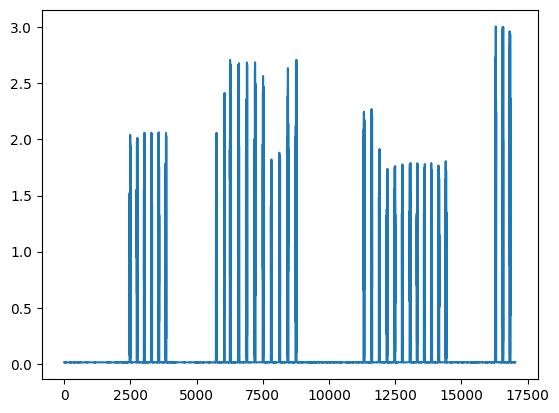

In [ ]:
plt.plot(avg_power)
#np.where(avg_power>1)[0]
avg_power.mean()+avg_power.std()*2

Histogram of average power of each segment of size `num_samples`.

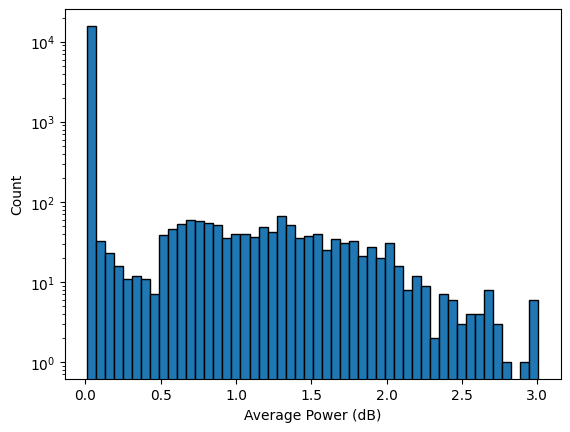

In [ ]:
plt.hist(np.array(avg_power), bins=50, log=True, edgecolor='black')
plt.xlabel('Average Power (dB)')
plt.ylabel('Count')
plt.show()

A PSD threshold value of 3 standard deviations from the mean of all average power values for all segments was used to identify bursts. Average PSD values don't exhibit a Gaussian distribution so this is just an arbitrary threshold.


In [ ]:
psd_threshold = avg_power.mean() + avg_power.std()*3
print(psd_threshold)
burst_idx_diff_threshold = 1000

# sample indices of bursts
burst_idx = np.where(avg_power>psd_threshold)[0]

# array of difference in sample indices that are greater than
# or equal to burst_idx_diff_threshold
difference_array = burst_idx[1:] - burst_idx[0:-1]
#burst_idx_diff = np.where(burst_idx[1:] -\
#          burst_idx[0:-1]>=burst_idx_diff_threshold)[0]

burst_idx_diff =np.where((difference_array>=1000) & (difference_array<5000))[0]
#unique, counts = np.unique(burst_idx_diff, return_counts=True)
#unique, counts

1.130909504276625


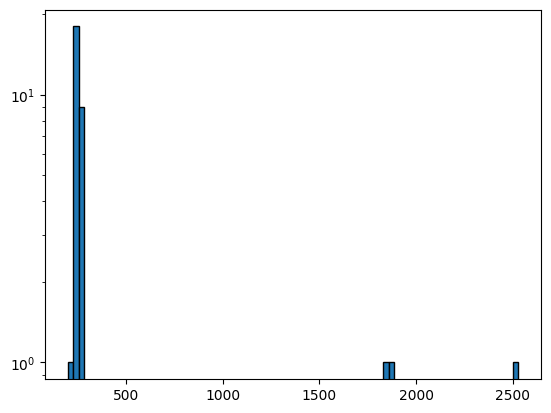

In [ ]:
samp_between_bursts = 10
burst_idx_diff = burst_idx[1:] - burst_idx[0:-1]
burst_idx_mask = burst_idx_diff>samp_between_bursts
plt.hist(burst_idx_diff[burst_idx_mask], bins=80, log=True,  edgecolor='black');

In [ ]:
# Identify indices in IQ data of the start and stop of bursts.
iq_burst_idx = []
#b_idx_mod = len(burst_idx_diff)%2
b_idx_len = len(burst_idx_diff)

for _, b_idx in enumerate(burst_idx_diff):
  if _==0 and b_idx_len==1:
    iq_burst_idx.append((burst_idx[:b_idx].min(),  burst_idx[:b_idx].max()))
    #iq_burst_idx.append((0, b_idx))
  elif _==0 and b_idx_len>1:
    iq_burst_idx.append((burst_idx[:b_idx].min(),  burst_idx[:b_idx].max()))
  elif _!=b_idx_len:
    iq_burst_idx.append((burst_idx[burst_idx_diff[_-1]:burst_idx_diff[_]].min(),
                         burst_idx[burst_idx_diff[_-1]:burst_idx_diff[_]].max()))

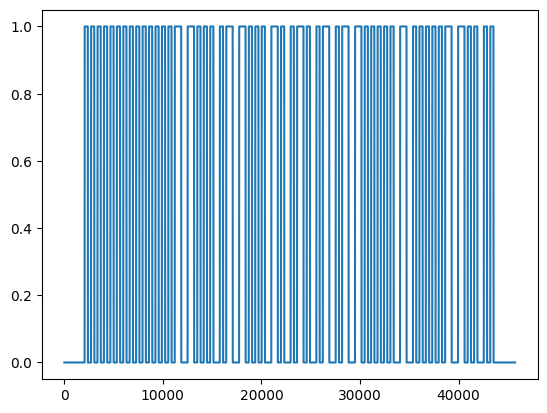

In [ ]:
ii=0
xx = np.absolute(complex_data[iq_burst_idx[ii][0]*1024-2500:iq_burst_idx[ii][1]*1024-1375000])
xx[np.where(xx<1000)[0]]=0
xx[np.where(xx>=1000)[0]]=1

fig, ax = plt.subplots()

ax.plot(xx)
plt.show()

[0. 1.] [273 327]


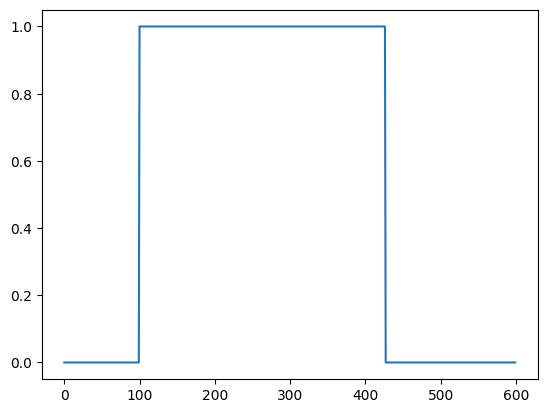

In [ ]:
first_one_idx = np.where(xx==1)[0][0]
last_one_idx = np.where(xx==1)[0][-1]
xx_slice = xx[first_one_idx-100: first_one_idx+500]
plt.plot(xx_slice)
vals, counts = np.unique(xx_slice, return_counts=True)
print(vals, counts)

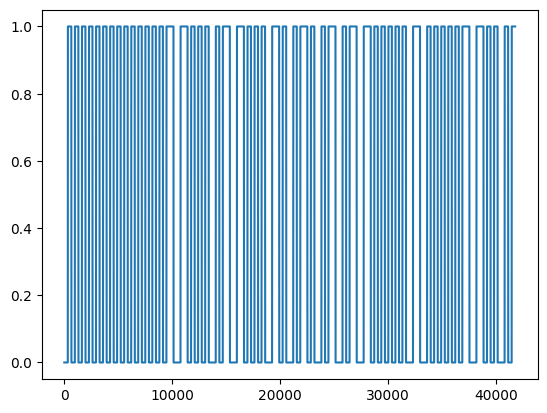

In [ ]:
half_symbol_len = counts[1]

burst_example = np.concatenate([np.zeros(half_symbol_len),
                                xx[first_one_idx:last_one_idx+1]])
plt.plot(burst_example)
plt.show()

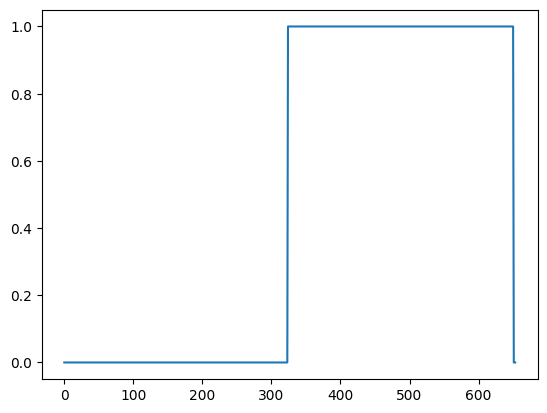

In [ ]:
symbol_len = 2*half_symbol_len
num_bits = 64
frame_idx=3
l_idx = frame_idx*symbol_len
r_idx = l_idx+symbol_len
plt.plot(burst_example[l_idx:r_idx])
plt.show()

In [ ]:
bit_string = ''
for frame in np.arange(num_bits):
  l_idx = frame*symbol_len
  r_idx = l_idx+symbol_len
  starting_val = int(burst_example[l_idx:r_idx][100])
  ending_val = int(burst_example[l_idx:r_idx][-300])
  if starting_val == 0 and ending_val == 1:
    bit_string = bit_string+'0'
  if starting_val == 1 and ending_val == 0:
    bit_string = bit_string+'1'

print(bit_string)
print(len(bit_string))

0000000000000001011110010111101100110010010111111010000001011100
64


In [ ]:
samp_per_packet = burst_example.shape[0]
num_symbols = 128
samples_per_symbol = samp_per_packet//num_symbols

print(samples_per_symbol)

326


In [ ]:
# symbol rate
symbol_rate=int((1/samples_per_symbol)*sr)

(sr/symbol_rate)/4

81.51066431191414

In [ ]:
sr*(4820.4248 - 4686.2071)/1e6

322.12248000000034

In [ ]:
sr*(4956.6761 - 4820.4248)/1e6

327.00311999999974

In [ ]:
gr = '01010101010101010101010101010110011010101001011001101010100110100101101001011001011001101010101010011001010101010110011010100101'
print(len(gr))

128


In [ ]:
#IEEE 802.3 and .4 logic 0 is high low, logic 1 is low high
packet='010101010101010101010101010101100110101010010110011010101001101001011010010110010110011010101010100110010101010101100110101001010'#gr
decode = ''
for i in range(0, len(packet) - 1, 2):
    bits = packet[i] + packet[i + 1]
    if(bits == '10'):
        decode += '0'
    elif(bits == '01'):
        decode += '1'
    else:
        i -= 1
print(decode, len(decode))

1111111111111110100001101000010011001101101000000101111110100011 64


In [ ]:
gr[26:26+9]

'101100110'